In [5]:
PATH_TO_CSV = "/home/mehdi/minecraft-copilot-ml/output/lightning_logs/version_1/metrics.csv"
PATH_TO_BEST_MODEL = "/home/mehdi/minecraft-copilot-ml/output/best_model.pth"

<Axes: xlabel='epoch', ylabel='val_loss_epoch'>

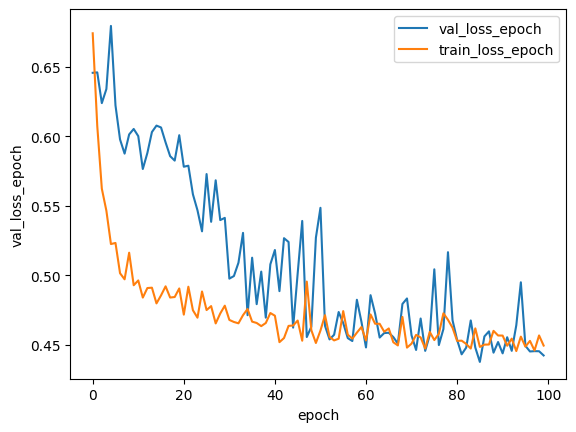

In [6]:
from seaborn import lineplot
import pandas as pd

df = pd.read_csv(PATH_TO_CSV)
lineplot(data=df, x='epoch', y='val_loss_epoch', label='val_loss_epoch')
lineplot(data=df, x='epoch', y='train_loss_epoch', label='train_loss_epoch')